<a href="https://colab.research.google.com/github/Rakib911Hossan/hate_speech_detection/blob/main/subtask_1a_xlm_roberta_recovery_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Hate Speech Identification Shared Task](https://multihate.github.io/): Subtask 1A at [BLP Workshop](https://blp-workshop.github.io/) @IJCNLP-AACL 2025

This shared task is designed to identify the type of hate, its severity, and the targeted group from social media content. The goal is to develop robust systems that advance research in this area.

In this subtask, given a Bangla text collected from YouTube comments, categorize whether it contains abusive, sexism, religious hate, political hate, profane, or none.

### Downloading dataset from github

In [ ]:
!wget https://raw.githubusercontent.com/AridHasan/blp25_task1/refs/heads/main/data/subtask_1A/blp25_hatespeech_subtask_1A_train.tsv
!wget https://raw.githubusercontent.com/AridHasan/blp25_task1/refs/heads/main/data/subtask_1A/blp25_hatespeech_subtask_1A_dev.tsv
!wget https://raw.githubusercontent.com/AridHasan/blp25_task1/refs/heads/main/data/subtask_1A/blp25_hatespeech_subtask_1A_dev_test.tsv

--2025-08-26 07:44:56--  https://raw.githubusercontent.com/AridHasan/blp25_task1/refs/heads/main/data/subtask_1A/blp25_hatespeech_subtask_1A_train.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8002036 (7.6M) [text/plain]
Saving to: ‘blp25_hatespeech_subtask_1A_train.tsv’

blp25_hatespeech_su 100%[===================>]   7.63M  --.-KB/s    in 0.1s    

2025-08-26 07:44:56 (76.2 MB/s) - ‘blp25_hatespeech_subtask_1A_train.tsv’ saved [8002036/8002036]

--2025-08-26 07:44:56--  https://raw.githubusercontent.com/AridHasan/blp25_task1/refs/heads/main/data/subtask_1A/blp25_hatespeech_subtask_1A_dev.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.co

### installing required libraries.
 - transformers
 - datasets
 - evaluate
 - accelerate

In [ ]:
!pip install transformers
!pip install datasets
!pip install evaluate
# !pip install --upgrade accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.3 MB/s eta 0:00:00


#### importing required libraries and setting up logger

In [ ]:
import logging
import os
import random
import sys
from dataclasses import dataclass, field
from typing import Optional
import pandas as pd
import datasets
import evaluate
import numpy as np
from datasets import load_dataset, Dataset, DatasetDict
import torch

import transformers
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    EvalPrediction,
    HfArgumentParser,
    PretrainedConfig,
    Trainer,
    TrainingArguments,
    default_data_collator,
    set_seed,
)
from transformers.trainer_utils import get_last_checkpoint
from transformers.utils import check_min_version, send_example_telemetry
from transformers.utils.versions import require_version


logger = logging.getLogger(__name__)

logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    handlers=[logging.StreamHandler(sys.stdout)],
)

### Defining the training, validation, and test data

In [ ]:
train_file = 'blp25_hatespeech_subtask_1A_train.tsv'
validation_file = 'blp25_hatespeech_subtask_1A_dev.tsv'
test_file = 'blp25_hatespeech_subtask_1A_dev_test.tsv'

In [ ]:
train_df = pd.read_csv(train_file, sep='\t')

In [ ]:
# # Shape of dataset
# print("Shape:", train_df.shape)

# # Column names
# print("Columns:", train_df.columns)

# Data types & non-null counts
print(train_df.info())

# First few rows
print(train_df.head())

# Last few rows
print(train_df.tail())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35522 entries, 0 to 35521
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      35522 non-null  int64 
 1   text    35522 non-null  object
 2   label   15568 non-null  object
dtypes: int64(1), object(2)
memory usage: 832.7+ KB
None
       id                                               text    label
0  147963  ধন্যবাদ বর্ডার গার্ড দেরকে এভাবে পাহারা দিতে হ...      NaN
1  214275  ছোটবেলায় অনেক কষ্ট করে কিছু গালাগালি শিখছিলাম...      NaN
2  849172          অতিরিক্ত এ নিজেকে বাদুর বানাইয়া ফেলছেন রে  Abusive
3  821985  চিন ভারত রাশিয়া এই তিন দেশ এক থাকলে বিশ্বকে শা...      NaN
4  477288  এটার বিচার কে করবেযে বিচার করবে সেই তো হলো এই ...  Abusive
           id                                               text    label
35517  790325  তইওয়ানের এত ক্ষমতা হয়নি যে এক টুকরো জায়গা নষ্ট...      NaN
35518  328377                                চুরের ঘরের চুর হালা  Profane
35519   69803

In [ ]:
# Numeric summary
print(train_df.describe())

# Categorical summary
print(train_df.describe(include='object'))

# Unique values per column
for col in train_df.columns:
    print(f"{col}: {train_df[col].nunique()} unique values")


                  id
count   35522.000000
mean   470131.934435
std    271256.805054
min        96.000000
25%    235179.000000
50%    470483.000000
75%    705906.250000
max    939762.000000
                                                     text    label
count                                               35522    15568
unique                                              35522        5
top     ছেমরি হলো মাহফুজ রহমান কে ব্যাবহার করে কেরিয়ার...  Abusive
freq                                                    1     8212
id: 35522 unique values
text: 35522 unique values
label: 5 unique values


In [ ]:
print(train_df.isnull().sum())  # Count missing values
print(train_df.isna().mean()*100)  # Percentage of missing values


id           0
text         0
label    19954
dtype: int64
id        0.000000
text      0.000000
label    56.173639
dtype: float64


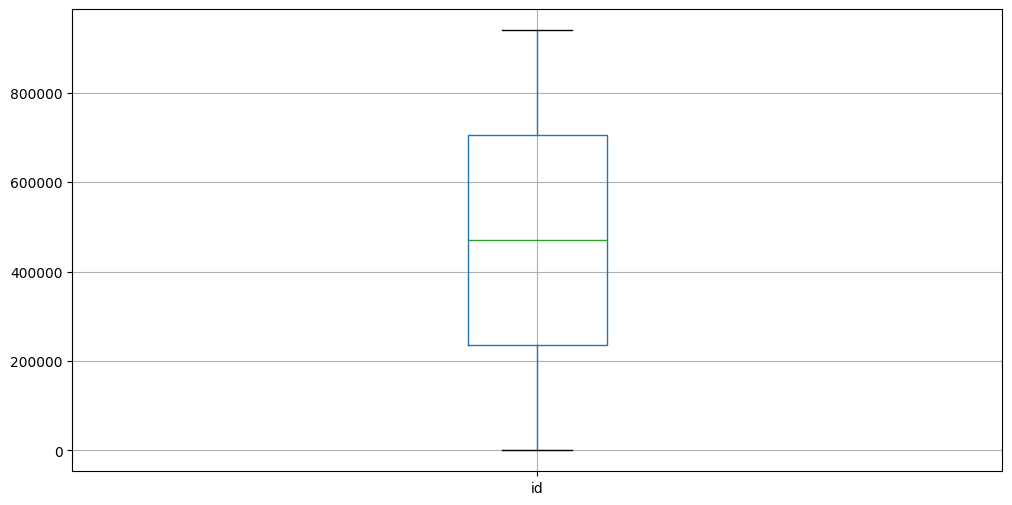

Outliers detected: 0


In [ ]:
import matplotlib.pyplot as plt

# Boxplot for outliers
train_df.boxplot(figsize=(12,6))
plt.show()

# Z-score or IQR method
from scipy import stats
import numpy as np

z_scores = np.abs(stats.zscore(train_df.select_dtypes(include=np.number)))
outliers = (z_scores > 3).sum()
print("Outliers detected:", outliers.sum())


In [ ]:
if 'target' in train_df.columns:
    print(train_df['target'].value_counts(normalize=True))
    train_df['target'].value_counts().plot(kind='bar')
    plt.show()


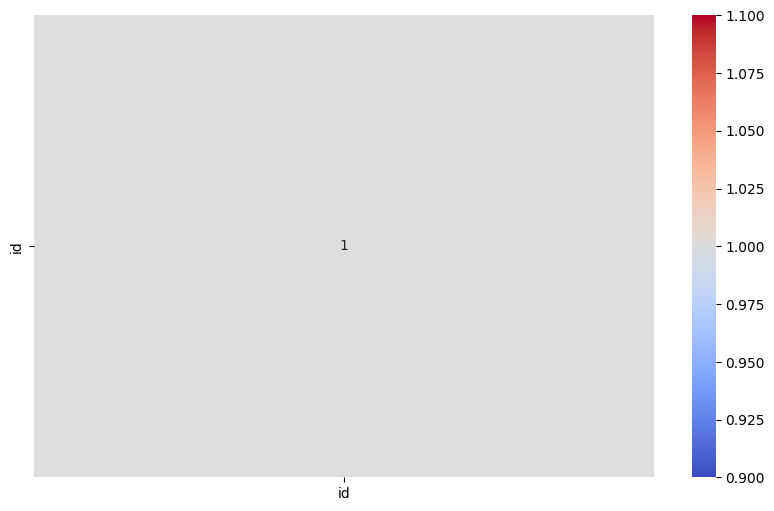

In [ ]:
import seaborn as sns

corr = train_df.corr(numeric_only=True)
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()


### Disable wandb

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

### Setting up the training parameters

In [ ]:
from transformers import TrainingArguments, EarlyStoppingCallback

# 🎯 OPTIMIZED CONFIGURATION BASED ON YOUR RESULTS
training_args = TrainingArguments(
    output_dir="./xlm_roberta_recovery/",
    overwrite_output_dir=True,

    # 🔧 ADJUSTED LEARNING SCHEDULE - Your model peaked early then overfitted
    learning_rate=10e-6,                    # Lower LR for more stable convergence
    num_train_epochs=8,                    # More epochs with early stopping
    warmup_ratio=0.15,                     # Longer warmup for stability
    lr_scheduler_type="cosine",            # Smoother LR decay
    # 🛡️ STRONGER REGULARIZATION - Combat the overfitting you observed
    weight_decay=0.01,                     # Increase from your 0.01
    max_grad_norm=0.5,                     # Tighter gradient clipping
    dataloader_drop_last=True,             # More consistent batch sizes

    # ✅ KEEP YOUR SUCCESSFUL BATCH CONFIGURATION
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=1,

    # 🎯 EARLY STOPPING - Prevent the Epoch 4 overfitting you experienced
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,

    # 📊 COMPREHENSIVE MONITORING
    logging_steps=250,                     # More frequent logging
    eval_steps=None,                       # Eval every epoch
    save_total_limit=3,                    # Keep only best 3 checkpoints

    # 🔧 SYSTEM OPTIMIZATIONS
    report_to=None,
    dataloader_num_workers=2,
    fp16=True,                            # Mixed precision for efficiency
    group_by_length=True,                 # Batch similar lengths together
)

# 🛑 MANDATORY EARLY STOPPING - Based on your overfitting pattern
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=2,            # Stop after 2 epochs without improvement
    early_stopping_threshold=0.001        # Minimum improvement threshold
)



# 🎯 OPTIMIZED DATA PARAMETERS
max_train_samples = None
max_eval_samples = None
max_predict_samples = None
max_seq_length = 512
batch_size = 8


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
transformers.utils.logging.set_verbosity_info()

log_level = training_args.get_process_log_level()
logger.setLevel(log_level)
datasets.utils.logging.set_verbosity(log_level)
transformers.utils.logging.set_verbosity(log_level)
transformers.utils.logging.enable_default_handler()
transformers.utils.logging.enable_explicit_format()
logger.warning(
    f"Process rank: {training_args.local_rank}, device: {training_args.device}, n_gpu: {training_args.n_gpu}"
    + f" distributed training: {bool(training_args.local_rank != -1)}, 16-bits training: {training_args.fp16}"
)
logger.info(f"Training/evaluation parameters {training_args}")

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=True,
dataloader_num_workers=2,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=Interval

#### Defining the Model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Change only the model name
# Model setup
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=5  # Your 5 classes
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

[INFO|configuration_utils.py:752] 2025-08-26 07:46:21,976 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/e73636d4f797dec63c3081bb6ed5c7b0bb3f2089/config.json
[INFO|configuration_utils.py:817] 2025-08-26 07:46:21,992 >> Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.55.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}



sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

[INFO|tokenization_utils_base.py:2067] 2025-08-26 07:46:23,459 >> loading file sentencepiece.bpe.model from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/e73636d4f797dec63c3081bb6ed5c7b0bb3f2089/sentencepiece.bpe.model
[INFO|tokenization_utils_base.py:2067] 2025-08-26 07:46:23,460 >> loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/e73636d4f797dec63c3081bb6ed5c7b0bb3f2089/tokenizer.json
[INFO|tokenization_utils_base.py:2067] 2025-08-26 07:46:23,461 >> loading file added_tokens.json from cache at None
[INFO|tokenization_utils_base.py:2067] 2025-08-26 07:46:23,461 >> loading file special_tokens_map.json from cache at None
[INFO|tokenization_utils_base.py:2067] 2025-08-26 07:46:23,462 >> loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/e73636d4f797dec63c3081bb6ed5c7b0bb3f2089/tokenizer_config.json
[INFO|tokenization_utils_base.py:2067] 2025-08

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

[INFO|modeling_utils.py:1309] 2025-08-26 07:46:47,653 >> loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/e73636d4f797dec63c3081bb6ed5c7b0bb3f2089/model.safetensors
[INFO|modeling_utils.py:5604] 2025-08-26 07:46:47,801 >> Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identic

#### setting the random seed

In [ ]:
set_seed(training_args.seed)

#### Loading data files

In [ ]:
l2id = {'None': 0, 'Religious Hate': 1, 'Sexism': 2, 'Political Hate': 3, 'Profane': 4, 'Abusive': 5}
train_df = pd.read_csv(train_file, sep='\t')
# print(train_df['label'])
train_df['label'] = train_df['label'].map(l2id).fillna(0).astype(int)
train_df = Dataset.from_pandas(train_df)
validation_df = pd.read_csv(validation_file, sep='\t')
validation_df['label'] = validation_df['label'].map(l2id).fillna(0).astype(int)
validation_df = Dataset.from_pandas(validation_df)
test_df = pd.read_csv(test_file, sep='\t')
#test_df['label'] = test_df['label'].map(l2id)
test_df = Dataset.from_pandas(test_df)

data_files = {"train": train_df, "validation": validation_df, "test": test_df}
for key in data_files.keys():
    logger.info(f"loading a local file for {key}")
raw_datasets = DatasetDict(
    {"train": train_df, "validation": validation_df, "test": test_df}
)

INFO:__main__:loading a local file for train
INFO:__main__:loading a local file for validation
INFO:__main__:loading a local file for test


In [ ]:
len(test_df['id'])

2512

##### Extracting number of unique labels

In [ ]:
# Labels
label_list = raw_datasets["train"].unique("label")
print(label_list)
label_list.sort()  # sort the labels for determine
num_labels = len(label_list)

[0, 5, 4, 1, 3, 2]


### Loading Pretrained Configuration, Tokenizer and Model

In [ ]:
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    finetuning_task=None,
    cache_dir=None,
    revision="main",
    use_auth_token=None,
)

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    cache_dir=None,
    use_fast=True,
    revision="main",
    use_auth_token=None,
)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    from_tf=bool(".ckpt" in model_name),
    config=config,
    cache_dir=None,
    revision="main",
    use_auth_token=None,
    ignore_mismatched_sizes=False,
)

[INFO|configuration_utils.py:752] 2025-08-26 07:46:48,345 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/e73636d4f797dec63c3081bb6ed5c7b0bb3f2089/config.json
[INFO|configuration_utils.py:817] 2025-08-26 07:46:48,347 >> Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_

#### Preprocessing the raw_datasets

In [ ]:
non_label_column_names = [name for name in raw_datasets["train"].column_names if name != "label"]
sentence1_key= non_label_column_names[1]

# Padding strategy
padding = "max_length"

# Some models have set the order of the labels to use, so let's make sure we do use it.
label_to_id = None
if (model.config.label2id != PretrainedConfig(num_labels=num_labels).label2id):
    # Some have all caps in their config, some don't.
    label_name_to_id = {k.lower(): v for k, v in model.config.label2id.items()}
    if sorted(label_name_to_id.keys()) == sorted(label_list):
        label_to_id = {i: int(label_name_to_id[label_list[i]]) for i in range(num_labels)}
    else:
        logger.warning(
            "Your model seems to have been trained with labels, but they don't match the dataset: ",
            f"model labels: {sorted(label_name_to_id.keys())}, dataset labels: {sorted(label_list)}."
            "\nIgnoring the model labels as a result.",)

if label_to_id is not None:
    model.config.label2id = label_to_id
    model.config.id2label = {id: label for label, id in config.label2id.items()}

if 128 > tokenizer.model_max_length:
    logger.warning(
        f"The max_seq_length passed ({128}) is larger than the maximum length for the"
        f"model ({tokenizer.model_max_length}). Using max_seq_length={tokenizer.model_max_length}.")
max_seq_length = min(128, tokenizer.model_max_length)

def preprocess_function(examples):
    # Tokenize the texts
    args = (
        (examples[sentence1_key],))
    result = tokenizer(*args, padding=padding, max_length=max_seq_length, truncation=True)

    # Map labels to IDs (not necessary for GLUE tasks)
    if label_to_id is not None and "label" in examples:
        result["label"] = [(label_to_id[l] if l != -1 else -1) for l in examples["label"]]
    return result
raw_datasets = raw_datasets.map(
    preprocess_function,
    batched=True,
    load_from_cache_file=True,
    desc="Running tokenizer on dataset",
)


Running tokenizer on dataset:   0%|          | 0/35522 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/2512 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/2512 [00:00<?, ? examples/s]

#### Finalize the training data for training the model

In [ ]:
if "train" not in raw_datasets:
    raise ValueError("requires a train dataset")
train_dataset = raw_datasets["train"]
if max_train_samples is not None:
    max_train_samples_n = min(len(train_dataset), max_train_samples)
    train_dataset = train_dataset.select(range(max_train_samples_n))

In [ ]:
train_dataset

Dataset({
    features: ['id', 'text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 35522
})

#### Finalize the development/evaluation data for evaluating the model

In [ ]:
if "validation" not in raw_datasets:
    raise ValueError("requires a validation dataset")
eval_dataset = raw_datasets["validation"]
if max_eval_samples is not None:
    max_eval_samples_n = min(len(eval_dataset), max_eval_samples)
    eval_dataset = eval_dataset.select(range(max_eval_samples_n))

#### Finalize the test data for predicting the unseen test data using the model

In [ ]:
if "test" not in raw_datasets and "test_matched" not in raw_datasets:
    raise ValueError("requires a test dataset")
predict_dataset = raw_datasets["test"]
if max_predict_samples is not None:
    max_predict_samples_n = min(len(predict_dataset), max_predict_samples)
    predict_dataset = predict_dataset.select(range(max_predict_samples_n))

#### Log a few random samples from the training set

In [ ]:
for index in random.sample(range(len(train_dataset)), 3):
    logger.info(f"Sample {index} of the training set: {train_dataset[index]}.")

INFO:__main__:Sample 7296 of the training set: {'id': 660, 'text': 'সরকারের দায়িত্বপ্রাপ্ত সংস্থা সকল বাণিজ্যিক ভবন গুলোকে বছরে অন্তত একবার পরিদর্শন করে রিপোর্ট প্রদান করবেন একটা বাণিজ্যিক ভবনে নিরাপত্তার সকল ব্যবস্থা থাকা উচিত কিন্তু এই সব সম্ভবের দেশে কিছুই করা হয় না এই দেশে মানুষের জীবনের কোন দাম নেই তাই কেউ কোনকিছুর তদারকিরও দরকার মনে করে না', 'label': 3, 'input_ids': [0, 122305, 155189, 138641, 147274, 52968, 223148, 149813, 6, 34653, 2937, 212543, 233823, 8339, 24256, 243049, 5507, 192565, 105314, 84016, 71896, 223148, 149813, 956, 130058, 999, 52968, 105963, 143892, 190185, 46729, 6386, 30511, 159108, 896, 95679, 24432, 2730, 7185, 9681, 4480, 6386, 95679, 81385, 48940, 896, 33237, 177775, 41819, 79073, 114731, 33237, 26061, 171730, 999, 38254, 65185, 26061, 999, 4876, 219840, 59019, 5507, 4480, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

#### Get the metric function `accuracy`

In [ ]:
metric = evaluate.load("accuracy")

#### Predictions and label_ids field and has to return a dictionary string to float.

In [ ]:
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)
    return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}


#### Data Collator

In [ ]:
data_collator = default_data_collator

#### Initialize our Trainer

In [ ]:
train_dataset = train_dataset.remove_columns("id")
eval_dataset = eval_dataset.remove_columns("id")

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

/tmp/ipython-input-1049306949.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
[INFO|trainer.py:757] 2025-08-26 07:47:07,013 >> Using auto half precision backend


#### Training our model

In [ ]:
train_result = trainer.train()
metrics = train_result.metrics
max_train_samples = (
    max_train_samples if max_train_samples is not None else len(train_dataset)
)
metrics["train_samples"] = min(max_train_samples, len(train_dataset))



[INFO|trainer.py:932] 2025-08-26 07:47:07,570 >> The following columns in the Training set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:2433] 2025-08-26 07:47:20,658 >> ***** Running training *****
[INFO|trainer.py:2434] 2025-08-26 07:47:20,659 >>   Num examples = 35,522
[INFO|trainer.py:2435] 2025-08-26 07:47:20,660 >>   Num Epochs = 8
[INFO|trainer.py:2436] 2025-08-26 07:47:20,661 >>   Instantaneous batch size per device = 8
[INFO|trainer.py:2439] 2025-08-26 07:47:20,662 >>   Total train batch size (w. parallel, distributed & accumulation) = 8
[INFO|trainer.py:2440] 2025-08-26 07:47:20,664 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:2441] 2025-08-26 07:47:20,665 >>   Total optimization steps = 35,520
[INFO|trainer.py:2442] 2025-08-26 07:47:20,667 >>   Number of trainable paramete

Epoch,Training Loss,Validation Loss,Accuracy
1,0.894200,0.798117,0.677150
2,0.803900,0.722054,0.710589
3,0.686700,0.719878,0.721736
4,0.660400,0.760376,0.730494
5,0.580800,0.748642,0.729299
6,0.490000,0.871513,0.724124
7,0.430000,0.912873,0.721338
8,0.425900,0.945637,0.724920


[INFO|trainer.py:932] 2025-08-26 07:56:56,394 >> The following columns in the Evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:4408] 2025-08-26 07:56:56,730 >> 
***** Running Evaluation *****
[INFO|trainer.py:4410] 2025-08-26 07:56:56,731 >>   Num examples = 2512
[INFO|trainer.py:4413] 2025-08-26 07:56:56,732 >>   Batch size = 8
[INFO|trainer.py:4074] 2025-08-26 07:57:02,317 >> Saving model checkpoint to ./xlm_roberta_recovery/checkpoint-4440
[INFO|configuration_utils.py:478] 2025-08-26 07:57:02,321 >> Configuration saved in ./xlm_roberta_recovery/checkpoint-4440/config.json
[INFO|modeling_utils.py:4180] 2025-08-26 07:57:23,386 >> Model weights saved in ./xlm_roberta_recovery/checkpoint-4440/model.safetensors
[INFO|tokenization_utils_base.py:2562] 2025-08-26 07:57:23,388 >> tokeni

#### Saving the tokenizer too for easy upload

In [ ]:
trainer.save_model()
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

[INFO|trainer.py:4074] 2025-08-26 09:10:56,216 >> Saving model checkpoint to ./xlm_roberta_recovery/
[INFO|configuration_utils.py:478] 2025-08-26 09:10:56,219 >> Configuration saved in ./xlm_roberta_recovery/config.json
[INFO|modeling_utils.py:4180] 2025-08-26 09:11:16,664 >> Model weights saved in ./xlm_roberta_recovery/model.safetensors
[INFO|tokenization_utils_base.py:2562] 2025-08-26 09:11:16,666 >> tokenizer config file saved in ./xlm_roberta_recovery/tokenizer_config.json
[INFO|tokenization_utils_base.py:2571] 2025-08-26 09:11:16,669 >> Special tokens file saved in ./xlm_roberta_recovery/special_tokens_map.json


***** train metrics *****
  epoch                    =        8.0
  total_flos               = 17408356GF
  train_loss               =       0.65
  train_runtime            = 1:23:35.53
  train_samples            =      35522
  train_samples_per_second =     56.659
  train_steps_per_second   =      7.082


#### Evaluating our model on validation/development data

In [ ]:
logger.info("*** Evaluate ***")

metrics = trainer.evaluate(eval_dataset=eval_dataset)

max_eval_samples = (
    max_eval_samples if max_eval_samples is not None else len(eval_dataset)
)
metrics["eval_samples"] = min(max_eval_samples, len(eval_dataset))

trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

INFO:__main__:*** Evaluate ***
[INFO|trainer.py:932] 2025-08-26 09:11:16,775 >> The following columns in the Evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:4408] 2025-08-26 09:11:17,131 >> 
***** Running Evaluation *****
[INFO|trainer.py:4410] 2025-08-26 09:11:17,132 >>   Num examples = 2512
[INFO|trainer.py:4413] 2025-08-26 09:11:17,133 >>   Batch size = 8


***** eval metrics *****
  epoch                   =        8.0
  eval_accuracy           =     0.7305
  eval_loss               =     0.7604
  eval_runtime            = 0:00:06.20
  eval_samples            =       2512
  eval_samples_per_second =    404.922
  eval_steps_per_second   =     50.615


### Predecting the test data

In [ ]:
id2l = {v: k for k, v in l2id.items()}
logger.info("*** Predict ***")
#predict_dataset = predict_dataset.remove_columns("label")
ids = predict_dataset['id']
predict_dataset = predict_dataset.remove_columns("id")
predictions = trainer.predict(predict_dataset, metric_key_prefix="predict").predictions
predictions = np.argmax(predictions, axis=1)
output_predict_file = os.path.join(training_args.output_dir, f"subtask_1A.tsv")
if trainer.is_world_process_zero():
    with open(output_predict_file, "w") as writer:
        logger.info(f"***** Predict results *****")
        writer.write("id\tlabel\tmodel\n")
        for index, item in enumerate(predictions):
            item = label_list[item]
            item = id2l[item]
            writer.write(f"{ids[index]}\t{item}\t{model_name}\n")

INFO:__main__:*** Predict ***
[INFO|trainer.py:932] 2025-08-26 09:11:23,350 >> The following columns in the test set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:4408] 2025-08-26 09:11:23,662 >> 
***** Running Prediction *****
[INFO|trainer.py:4410] 2025-08-26 09:11:23,663 >>   Num examples = 2512
[INFO|trainer.py:4413] 2025-08-26 09:11:23,664 >>   Batch size = 8


INFO:__main__:***** Predict results *****


In [ ]:
ids[0]

879187

#### Saving the model into card

In [ ]:
kwargs = {"finetuned_from": model_name, "tasks": "text-classification"}
trainer.create_model_card(**kwargs)

[INFO|modelcard.py:456] 2025-08-26 09:11:29,974 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.7304936051368713}]}


In [ ]:
!zip subtask_1A.zip ./distilBERT_m/subtask_1A.tsv

	zip warning: name not matched: ./distilBERT_m/subtask_1A.tsv

zip error: Nothing to do! (subtask_1A.zip)
